# Teoría de Control práctica



## Variable de Proceso y Set Point
#### Variable de Proceso

La variable medida que se desea estabilizar (controlar) recibe el nombre de variable de proceso ("process value") y se abrevia **PV**.
Un buen ejemplo de variable de proceso es la temperatura, la cual mide el instrumento controlador mediante un termopar o una Pt100.

Otro ejemplo de PV puede ser un caudal (litros/minuto), éste se mide mediante algún sensor y su transductor adecuado que entreguen una señal de 4 a 20 mA proporcional al caudal. La corriente 4 a 20 mA entra en el controlador en donde se reescala a las unidades originales de la PV.

Ejemplos adicionales de PV pueden ser velocidad, presión, humedad, etc. cada una de las cuales se mide con el sensor apropiado y se convierten comúnmente a 4...20mA para ingresar al control.

En adelante durante todo este documento se usará la temperatura como ejemplo de PV por ser lo más intuitivo. Esto no hace perder generalidad, pues todo lo que se hable sobre temperatura y hornos es perfectamente análogo a sistemas de control de velocidad, presión, etc.

#### Set Point 

El valor prefijado (Set Point, **SP**) es el valor deseado de la variable de proceso, es el valor al cual el control debe mantener la PV.
Por ejemplo, en un horno si la temperatura actual es 155 °C y el controlador está programado para llevar la temperatura a 200°C, PV=155 y SP=200.

#### Error

Se define error como la diferencia entre la variable de proceso PV y el set point SP,
$$
E = SP - PV
$$
En el ejemplo anterior 
$$
\begin{align*}
E &= (SP - PV) \\
&= (200 ^\circ C - 155 ^\circ C)\\ 
&= 45 ^\circ C
\end{align*}
$$
Recuerde que el error será *positivo* cuando la temperatura sea menor que el set point, *PV < SP* .

## Control On/Off
Tomemos por ejemplo, el caso de un horno eléctrico. La temperatura aumenta al activar las resistencias de calentamiento mediante un contactor, gobernado a su vez por una relé o un transistor dentro del controlador.

El modo de control ON/OFF es el más elemental y consiste en dar la orden de calentamiento cuando la temperatura está por debajo de la temperatura deseada SP y luego desactivarla cuando la temperatura esté por arriba.






Populating the interactive namespace from numpy and matplotlib


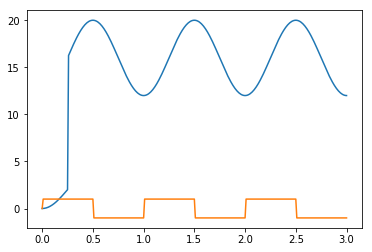

In [1]:
%pylab inline
def prueba2(x):
    escala = 2
    return where(x<0.26, escala * (1-cos(2*pi*x)), 4 *(4-cos(2*pi*x)) )  
    
freq = 1
t = linspace(0,3,301) #two cycles, 100 points each
y1 = pi*(sin(2*pi*freq*t))

sqwave = sign(sin(2*pi*freq*t)) #an actual square wave
plot( t, prueba2(t), t, sqwave)

Inevitablemente, debido a la inercia térmica del horno la temperatura estará continuamente fluctuando alrededor del SP.

La inercia térmica es consecuencia del retardo en la propagación del calor en el interior del horno desde la resistencia de calentamiento hasta el sensor de temperatura.

No es difícil imaginar que las **fluctuaciones aumentarán cuanto mayor sea la inercia térmica** del horno (retardo).

Evidentemente este algoritmo de control no es el más adecuado cuando se desea una temperatura constante y uniforme, pero sí ofrece la ventaja de provocar poco desgaste en los contactores, pues estos se activan y desactivan lo mínimo necesario.

#### Control On/Off con histéresis
Incluso para reducir aún más el desgaste a veces se efectúa un control ON/OFF con histéresis, es decir que el mando de calentamiento se activa unos pocos grados por arriba del SP y se desactiva unos grados por abajo del SP, provocando por supuesto una mayor fluctuación de la temperatura pero menos activaciones de los contactores.

El control ON/OFF con histéresis se usa generalmente en cámaras frigoríficas donde la temperatura debe estar dentro de un rango y se desea activar y desactivar lo menos posible los motores del sistema de refrigeración.

## PWM y tiempo de ciclo
#### Por que hace falta un control proporcional
Para poder controlar la temperatura con menos fluctuaciones, se debe poder entregar al horno una potencia gradual, en la medida requerida para mantenerlo a la temperatura deseada.

En el ejemplo anterior del control On/Off, el relé del mando de calentamiento estará activado 100%, entregando el máximo de potencia al horno o bien desactivado sin entregar potencia.

Un controlador proporcional entrega una potencia que varía en forma gradual entre 0 y 100% según se requiera y en forma proporcional al error (SP-PV).

Lo más natural para entregar una potencia que varia de 0% a 100% en forma continua seria usar un horno a petróleo o gas y que el control module la potencia mediante la llave de paso del combustible. La llave cerrada seria 0% de potencia y la llave totalmente abierta seria 100%.

El problema es que una **válvula motorizada** (gobernada mediante una señal 4..20 mA) es costosa y solo se justifica en aplicaciones que así lo requieran.

#### Tiempo de ciclo y PWM

Afortunadamente es posible modular de 0% a 100% la potencia que recibe un horno eléctrico mediante el mismo contactor que se usaría para un control on/off.

La idea es modular el tiempo de activación del contactor durante un lapso de tiempo fijo **tc**, llamado **tiempo de ciclo**, menor al tiempo característico de respuesta del horno de modo que el horno reciba finalmente un promedio de la potencia.

Para ilustrar esta técnica conocida como modulación por ancho de pulso (**PWM pulse width modulation**) recurrimos al siguiente ejemplo:

`Suponiendo que un horno posee un tiempo de respuesta de 1 minuto. Al aplicarle pulsos de calentamiento periódicos de 4 segundos, modulados en duración, el horno experimentará un calentamiento proporcional al promedio de tiempo que ha estado activado, sin que su temperatura siga las fluctuaciones de 4 segundos con que se aplica la potencia.`


`Supongamos que nuestro horno funciona con un calefactor de 1000W, si se requiere una potencia de 500W, equivalente a 50% de la total, entonces se activa 2 segundos el relé y se desactiva otros 2, para luego empezar otro ciclo.`

`El efecto neto será que el horno recibe 50% de la potencia pero la temperatura no fluctúa al ritmo del tiempo de ciclo pues este es menor al tiempo de respuesta del horno.`

`Siguiendo con el ejemplo, si hace falta 250W, es decir 25% de la potencia basta con tener 1 segundo activado el relé y 3 segundos desactivado.`

Para sistemas típicos el tiempo de ciclo se ajusta entre 1 y 200 segundos según sea el caso.

A mayor tiempo de ciclo, menos desgaste de los contactores, pero siempre tiene que ser inferior al **tiempo característico del sistema**.
La práctica recomendada es usar un tiempo de ciclo igual a la mitad del tiempo característico del sistema.


## Control Proporcional


Ya se menciono que el controlador proporcional entrega una potencia que varía en forma proporcional al error (SP-PV).
Para poner en marcha un controlador proporcional se deben fijar los siguientes parámetros:

- la temperatura deseada SP , por ej. SP = 200 °C
- la banda proporcional Pb, por ej. Pb = 10 %
- el tiempo de ciclo tc, por ej. tc = 4 seg.

Por supuesto no hace falta definir el tiempo de ciclo si se va a usar una válvula motorizada como mecanismo de control.

La **banda proporcional, Pb** se programa en el controlador como un porcentaje del SP.

Corresponde a una banda de temperatura situada por debajo del SP a lo largo de la cual, la potencia de salida variará proporcionalmente al error (SP-PV), disminuyendo cuanto más cercana sea la temperatura al SP.

Internamente el controlador realizará el cálculo del porcentaje de salida *Out* mediante la siguiente fórmula:
$$
Out\% = [100\% * \frac{E}{banda}] 
$$

$$
banda = Pb * \frac{SP}{100}
$$

$$
E = (SP - PV)
$$

El corchete [ ] se usa para indicar saturación, es decir que si al evaluar el interior, resulta mayor de 100%, se deja en 100% y si resulta 0 o negativo, se deja en 0%.

Para los valores del ejemplo SP=200°C y Pb=10%, la potencia determinada por el control variará a lo largo 20°C por debajo del SP.
$$
banda = Pb * \frac{SP}{100} = 10 *  \frac{200 ^\circ C }{ 100} = 20 ^\circ C
$$

Es decir que la banda a lo largo de la cual variará gradualmente la potencia será: 180°C...200°C.

Por ejemplo si la temperatura del horno es igual o menor de 180°C, la salida de control (potencia) será 100%.
Cuando la temperatura esté en la mitad de la banda, es decir en 190°C la salida será 50% :

$$
Out\% = [100\% * \frac{E}{banda}] = 100\% * \frac{(200-190)}{20} = 50\%
$$

Al llegar la temperatura a 200 °C la salida será 0% :

$$
Out\% = [100\% * \frac{(200-200)}{20}] = 0\%
$$

En la siguiente *Tabla 1*:

| PV [ºC] | Error (SP-PV)  [ºC] | Potencia 100% * E/20 [%] |
| :-----: | :-----------------: | :----------------------: |
|   210   |         -10         |            0             |
|   202   |         -2          |            0             |
|   200   |          0          |            0             |
|   199   |          1          |            5             |
|   198   |          2          |            10            |
|   195   |          5          |            25            |
|   190   |         10          |            50            |
|   185   |         15          |            75            |
|   182   |         18          |            90            |
|   181   |         19          |            95            |
|   180   |         20          |           100            |
|   170   |         30          |           100            |
|   110   |         90          |           100            |

se observa la potencia de salida ( Out% ) suministrada por el controlador a distintas temperaturas para este ejemplo.

En el siguiente gráfico de temperatura vs. tiempo se observa el comportamiento típico de un control proporcional.

No es difícil imaginar un control On/Off como uno proporcional con Pb=0%, pues cuando la temperatura esta arriba del SP ( E < 0 ) la salida es 0% y cuando la temperatura esta abajo del SP ( E > 0 ) es 100%.

#### Menor Pb hace más oscilatorio el sistema
Por lo tanto es importante tener presente que mientras menor sea la banda proporcional, el control proporcional se comportará más parecido al On/Off, es decir tenderá a presentar oscilaciones alrededor del SP.
#### Error estacionario
El control proporcional presenta el problema que la temperatura jamás se estabilizará justo en el valor del SP. En la práctica se estaciona siempre en un punto dentro de la banda proporcional, produciendo así el **error estacionario**.

La razón es fácil de entender recurriendo a nuestro ejemplo. Supongamos que la temperatura se estacionara en 200 °C en forma estable y permanente, entonces la salida sería 0%.

Pero siempre es necesario suministrarle al horno algo de potencia, al menos para compensar las pérdidas de calor al medio ambiente o calor contenido en el material que sale del horno.

Es evidentemente imposible que el horno se mantenga a 200°C con los calefactores permanentemente apagados.

Luego la temperatura tiene que descender un poco, lo suficiente para que la potencia suministrada por los calefactores sea igual a las pérdidas de energía del horno (energía que sale del horno).

Supongamos que para nuestro horno las pérdidas son tales que hace falta 25% de la potencia de los calefactores para mantener la temperatura alrededor del SP. La temperatura se estacionará establemente a 195°C, pues para esa temperatura la salida es 25% (ver *Tabla 1*). Al valor del error en este punto, 5°C, se le llama **error estacionario**.
#### Al disminuir Pb se disminuye el error estacionario
El error estacionario se puede reducir disminuyendo la banda proporcional. Dejamos como tarea al lector, el analizar la razón.
Para ello puede usar nuestro ejemplo del horno pero con Pb = 5% y calcular a que temperatura el control entregará un 25% de potencia.

Pero reducir mucho la banda propocional volverá oscilatorio nuestro sistema (más parecido a un On/Off), luego existe un límite inferior y siempre habrá algo de error estacionario.

En particular en los hornos que poseen mucha inercia térmica (mucho tiempo de retardo) se pueden presentar oscilaciones de la temperatura que solamente se podrán eliminar aumentando la banda proporcional y con ella aumentará el error estacionario.

Otro problema generado al aumentar la banda proporcional para eliminar las oscilaciones, es que el control pierde efectividad para responder rápidamente a perturbaciones externas (variaciones de la carga del horno, apertura de una puerta, etc.)

Para mejorar la respuesta a transcientes del control se utiliza un control proporcional derivativo. 

#### Ganancia proporcional Kp
Las fórmulas anteriores de cálculo de Out%, banda y Error se pueden expresar de otro modo en términos de la ganancia proporcional como:

$$
Out = [ Kp * E ]
$$

$$
Kp = \frac{100\%}{Pb * \frac{SP}{100\%} }
$$

Donde la constante Kp se conoce como **ganancia proporcional** del control y es inversamente proporcional a Pb.

En el control On/Off, Kp es muy grande, tiende a infinito.

### Ejercicios:

1. Un control proporcional tiene programado: SP=500 y Pb=5%. Si PV=490, ¿cuál será el valor de la salida de control? (Solución: Out=40% )

2. Un control proporcional de temperatura tiene programado SP=300ºC y Pb=20%. ¿A qué temperatura la salida de control será del 50%?  (Solución PV=270ºC)

3. Un horno con control proporcional de temperatura tiene programado: SP=800ºC y Pb=10%. El sistema está estable con una temperatura de 760ºC. 

   a) ¿Cuál es el error estacionario?
   b) Al colocar Pb=5%, ¿cuál será la temperatura aproximada a la que se estabilizará el horno?

(Soluciones: a) 40ºC , b) 780ºC)


## Control Proporcional Derivativo PD

Un control PD es uno proporcional al que se le agrega la capacidad de considerar también la velocidad de la temperatura en el tiempo.
De esta forma se puede "adelantar" la acción de control del mando de salida para obtener así una temperatura más estable.

Si la temperatura esta por debajo del SP, pero subiendo muy rápidamente y se va a pasar de largo el SP, entonces el control se adelanta y disminuye la potencia de los calefactores.

Y al contrario, si la temperatura es mayor que el SP, la salida debería ser 0% pero si el control estima que la temperatura baja muy rápido y se va pasar para abajo del SP, entonces le coloca algo de potencia a la salida para ir frenando el descenso brusco.

La acción derivativa es llada a veces **rate action** por algunos fabricantes de controles porque considera la "proporción de cambio" de la temperatura.

Para entender a fondo el control PD usaremos el mismo ejemplo anterior del horno pero agregamos ahora un nuevo parámetro llamado constante derivativa D, medido en segundos.

Internamente el controlador realizará ahora el cálculo:
$$
Out = [ 100\% * \frac {E- D * Vel}{banda}]
$$
   
$$
banda = \frac {Pb * SP}{100}
$$

Donde *Vel* es la velocidad de la temperatura medida por el controlador, en ºC/seg

Para este ejemplo fijamos D = 5 seg. y como antes SP=200 °C y Pb=10%.

Supongamos que en un momento dado, la temperatura del horno es de 185°C y está subiendo a una velocidad Vel= 2 °C/Seg.
En un control proporcional la salida debería ser del 75%, como se puede ver a continuación:

$$
Out = [100\% * \frac{E}{banda}] = 100\% * \frac {15^\circ C}{20^\circ C} = 75\%
$$

Pero en este caso el control PD toma en cuenta la velocidad de ascenso de la temperatura y la multiplica por la constante derivativa D y obtiene:


$$
\begin{align*}
Out &= [100\% * \frac{E - D * Vel}{banda}] \\
&= [100\% * \frac{15^\circ C - 5 seg * 2^\circ C/seg}{banda}]\\ 
&= [100\% * \frac{5^\circ C }{20^\circ C}]\\
&= 25\%
\end{align*}
$$

entonces a pesar que la temperatura actual es 185 °C, la salida es 25% en vez de 75%, al considerar la velocidad de ascenso de la temperatura.

La acción derivativa ocurre también fuera de la banda proporcional, en la *Tabla 2* se puede ver que para esta misma velocidad de ascenso de 2 °C/seg, la salida deja de ser 100% a partir de 170°C.

$$
\begin{align*}
Out &= [100\% * \frac{E - D * Vel}{banda}] \\
&= [100\% * \frac{(200-170)^\circ C - 5 seg * 2^\circ C/seg}{20^\circ C}]\\ 
&= [100\% * \frac{30^\circ C - 10^\circ C}{20^\circ C}]\\
&= [100\% * \frac{20^\circ C}{20^\circ C}]\\
&= 100\%
\end{align*}
$$

De la misma forma si la temperatura está sobre 200 °C pero descendiendo rápidamente, (velocidad negativa) por ejemplo -1°C/seg, entonces el control activará antes y con mayor potencia la salida intentando que no baje de 200 °C.



En la *Tabla 2* se observan las potencias a distintas temperaturas para 3 casos: control propocional, control PD con velocidad positiva y el mismo control PD con una velocidad negativa.

El control PD permite obtener una temperatura muy estable, sin oscilaciones y sin necesidad de sacrificar la respuesta ante perturbaciones aumentando la banda proporcional.

| PV (ºC) | P D =0 | PD D=5 seg, Vel= 2ºC/seg | PD D=5 seg, Vel = -1ºC/seg |
| :-----: | :----: | :----------------------: | :------------------------: |
|   204   |   0%   |            0%            |             5%             |
|   201   |   0%   |            0%            |            20%             |
|   200   |   0%   |            0%            |            25%             |
|   199   |   0%   |            0%            |            30%             |
|   198   |  10%   |            0%            |            35%             |
|   195   |  25%   |            0%            |            50%             |
|   190   |  50%   |            0%            |            75%             |
|   185   |  75%   |           25%            |            100%            |
|   182   |  90%   |           40%            |            100%            |
|   181   |  95%   |           45%            |            100%            |
|   180   |  100%  |           50%            |            100%            |
|   171   |  100%  |           95%            |            100%            |
|   170   |  100%  |           100%           |            100%            |


#### Ganancia derivativa
Dado que el error es E=SP -T, entonces la velocidad del error es:
$$
\frac{\mathrm{d}E }{\mathrm{d} t}=\frac{\mathrm{d} (SP-T)}{\mathrm{d} t}=-\frac{\mathrm{d}T }{\mathrm{d} t}= - (velocidad\,  de\,  la\,  temperatura)
$$

Luego el cálculo para el control PD se puede escribir:
$$
Out = [100\% * \frac{(E+D*\frac{\mathrm{d} E}{\mathrm{d} t} )}{ Pb* \frac{SP}{100\%}}]
$$

La forma alternativa de la fórmula, en términos de ganancias, K, es:
$$
Out = Kp * E * Kd * \frac{\mathrm{d} E}{\mathrm{d} t}
$$

$$
Kp= \frac {100\%}{ \frac {Pb*SP}{100\%}} 
$$

$$
Kd= \frac {100\% * D}{ \frac {Pb*SP}{100\%}} 
$$

Omitiendo los corchetes [] para simplificar la fórmula, pero se entiende que puede ocurrir la saturación en el cálculo y debe considerarse.

La constante Kd es la **ganancia derivativa**

### Ejercicios:

1. Un control PD tiene programado: SP=500, Pb=5% y D=10 seg. Si PV va en aumento de forma que incrementa 30 unidades cada minuto. En el instante que PV pase por 490, cual será el valor de la salida de control.? (Solución: Out=20% )

2. Un control PD tiene programado: SP=500, Pb=5% y D=10 seg. Si PV es superior a SP y va en descenso 90 unidades cada minuto. En el instante que PV sea 505, cual será el valor de la salida de control.?  (Solución Out=40%)



## Control Proporcional Integral PI

Retomaremos ahora el problema inconcluso del "error estacionario" tratado en la sección dedicada al control proporcional.
Para ello continuaremos utilizando el mismo ejemplo de nuestro horno a 200°C con Pb=10%, estacionado a 195°C para entregar 25% de potencia.

### Ajuste manual

Una forma de eliminar el error estacionario podría ser aumentando, mediante algún ajuste manual, un 25% la salida del control de modo que se estacione en 200°C.

Algunos controles antiguos permitían este ajuste y era llamado "**Manual reset**" o "Ajuste manual", el problema con este ajuste es que será efectivo mientras el horno esté con las mismas características que cuando se realizó.

Por ejemplo, si por alguna razón las pérdidas del horno disminuyen a 20%, la temperatura subirá por arriba de 200°C creando un error por arriba del SP.

### Control Proporcional Integral, PI

La forma efectiva de solucionar el problema del error estacionario es agregando al control proporcional el termino "Integral" llamado también a veces "**automatic reset**" o "**reset action**", nosotros lo llamaremos "**acción integral**".

El control será el mismo proporcional, pero a la salida se le suma la acción integral, que la corrige tomando en cuenta la magnitud del error y el tiempo que este ha permanecido.
Para ello se le programa al control una constante I, que es formalmente "la cantidad de veces que aumenta la acción proporcional por segundo".

La salida se corrige en una cantidad equivalente a la integral del error multiplicada por I.

Si parece complicado, es porque en realidad lo es un poco. Recurriendo a una analogía de un "saco" se podrá entender cómo opera la acción integral.
La integral del error es simplemente la suma acumulada de los errores medidos por el control cada segundo.
Es como un saco al cual se le va metiendo cada segundo una cantidad equivalente al error medido en ese segundo.

Si existe un error de 5°C, entonces el saco va creciendo, aumentando su tamaño cada segundo en una cantidad de 5.
Si el error es 0°C, entonces nada se le agrega al saco y este permanece en el mismo tamaño.
Pero si existe un error negativo, por ejemplo T=202 °C , entonces se le sacará 2 al saco cada segundo que permanezca este error y el tamaño del saco irá disminuyendo.

La idea es que la salida del control será la misma que en un control proporcional mas la magnitud del saco multiplicada por la constante I Internamente el control PI realiza el cálculo con la siguiente fórmula:

$$
\begin{align*}
Out &= [100\% * \frac{(E + I * Saco)}{banda}] \\
&= [ (100\% *\frac{E}{banda}) + (100\% * \frac{I * saco}{banda})]
\end{align*}
$$

y

$$
banda = \frac{Pb * SP}{100}
$$

Veamos que pasa a nuestro horno al colocarle una acción integral I=0.04/seg. y con SP=200°C, Pb=10%. (ver la tabla a continuación)
Con la temperatura estacionada en 195°C (por efecto de las pérdidas estimadas en 25%) a partir del tiempo 1, se activa la acción integral, desde ese momento cada segundo el saco aumenta en 5°C.

| Seg  | PV ºC | Error ºC | Saco ºC | PI 100% * (E + I * Saco)/20 |
| ---- | ----- | -------- | ------- | --------------------------- |
| 0    | 195   | 5        | 0       | 25%                         |
| 1    | 195   | 5        | 5       | 26%                         |
| 2    | 195   | 5        | 10      | 27%                         |
| 3    | 195   | 5        | 15      | 28%                         |
| 4    | 195   | 5        | 20      | 29%                         |
| 5    | 195   | 5        | 25      | 30%                         |
| 6    | 196   | 4        | 29      | 25.8%                       |
| 7    | 196   | 4        | 33      | 26.6%                       |
| 8    | 196   | 4        | 37      | 27.4%                       |
| 9    | 196   | 4        | 41      | 28.2%                       |
| 10   | 196   | 4        | 45      | 29%                         |
| 11   | 197   | 3        | 48      | 24.6%                       |
| 12   | 197   | 3        | 51      | 25.2%                       |
| 13   | 197   | 3        | 54      | 25.8%                       |
| 14   | 197   | 3        | 57      | 26.4%                       |
| 15   | 198   | 2        | 59      | 21.8%                       |
| 16   | 198   | 2        | 61      | 22.2%                       |
| 17   | 198   | 2        | 63      | 22.6%                       |
|      |       |          |         |                             |
| XX   | 200   | 0        | 125     | 25%                         |


La potencia de salida irá aumentando cada segundo, mientras el error
sea 5°C, en la cantidad:
$$
\frac{100\% * I * 4}{banda} =\frac{100\% * 0.04 * 4}{20} = 0.8\%
$$
El proceso continua de la misma forma aumentando el tamaño del saco hasta que en algún momento el error sea definitivamente eliminado, pues solo en ese momento se detendrá el incremento de la potencia de salida.
Entonces será el saco (la integral) quien supla el "ajuste" de la potencia necesaria para mantener el horno a 200°C.

Por muy pequeño que sea el valor programado de I, siempre corregirá el error estacionario, pero tardará más tiempo en hacerlo.

Al revés si se programa un valor excesivo de I, entonces la acción integral tendrá mucha fuerza en la salida y el sistema alcanzará rápidamente el SP, pero lo más probable es que se pase de largo por efectos de la inercia térmica.
Entonces la acción integral (con error negativo) será en sentido contrario, el saco irá disminuyendo rápidamente con la magnitud del error.
Como consecuencia habrá una excesiva disminución de la potencia de salida y la temperatura probablemente baje del SP, entrando así el sistema en un ciclo oscilatorio.

En la práctica normalmente **I deberá ser grande sólo en sistemas que reaccionan rápidamente**, (por ejemplo controles de velocidad de motores) y pequeño para sistemas lentos con mucha inercia. (Por ejemplo hornos)

En general los valores de la constante I son relativamente pequeños, para la mayoría de los sistemas el valor adecuado de I varia entre 0 y 0.08 1/seg.

Por ese motivo en muchos controles la cantidad I se programa multiplicada por 10000. Es decir que para tener una acción integral de 0.01/seg, se programa I'=0.01*10000=100.

### Ejercicios:
1. Revisar los cálculos presentados en la tabla anterior

2. Hacer una nueva tabla con los mismos valores de la tabla pero I=0.01 1/seg

#### Ganancia Integral

Internamente los controladores realizan el cálculo con la siguiente fórmula:
$$
Out = [\frac{100\%}{banda} *  (E + D * \frac{\mathrm{d}E }{\mathrm{d} t} + \frac{I}{10000} * \int E ) ]
$$
y
$$
banda = \frac{Pb *SP}{100\%} 
$$
Donde la integral del error en el tiempo corresponde al saco de nuestra analogía y SP, Pb, D, I son los números introducidos por el teclado del instrumento.

En términos de ganancias:
$$
Out = Kp * E + Kd * \frac{\mathrm{d}E }{\mathrm{d} t} + Ki * \int E ) 
$$

$$
Kp= \frac {100\%}{ \frac {Pb*SP}{100\%}} 
$$

$$
Kd= \frac {100\% * D}{ \frac {Pb*SP}{100\%}} 
$$

$$
Ki = \frac {100\% * I}{  \frac{ \frac {Pb*SP}{100\%}}{10000}} 
$$


Esta vez la constante **Ki** es la **ganancia integral**.
El efecto del término integral es más beneficioso que un simple “reset automático”, pues el sistema de control se convierte en uno de segundo orden en vez de primer orden.

Esto implica una mejor respuesta a transitorios y mejor rendimiento en general que un control proporcional con potencia de salida ajustada manualmente.

Para los familiarizados con teoría de control, las cosas se están volviendo más claras pues la ecuación anterior se acostumbra a escribir aplicada la transformada de Laplace a ambos lados.
$$
U = L(Out) = Kp*Le + s* Kd*Le +  \frac{ Ki}{s} * Le
$$
En la práctica al valor LE (transformada de Laplace del Error) se le aplicó previamente un operador "filtro paso bajo" de modo de ir filtrando el ruido en el PV medido.
$$
Le = \frac{LE}{(1+s*tf)}
$$
Donde tf es el tiempo de filtro en segundos. Este se programa en el "menú de configuración" del instrumento.

## Control Proporcional Integral Derivativo PID

A estas alturas el lector ya debe intuir que un control PID es un controlador proporcional con acción derivativa y acción integral simultáneamente superpuestas.

Asímismo el lector ya debe estarse preguntando cómo elegir los valores de los parámetros Pb, D, I, tc que debe introducir en su controlador PID.
Lamentablemente no existe una respuesta sencilla a esta pregunta.

Existe un solo conjunto de valores Pb, D, I que darán el rendimiento óptimo y encontrarlos requiere: conocimientos teóricos, habilidad obtenida mediante la experiencia y suerte.

Pero no hay porque desanimarse, en realidad cualquier conjunto de valores cercano al óptimo brindará un rendimiento aceptable y probablemente casi igual al óptimo.

Además afortunadamente existen un par de métodos experimentales para encontrar una aproximación de estos parámetros.
Pero antes de entrar en detalle de cómo encontrarlos, definiremos algunos conceptos útiles.

#### Estabilidad del sistema

Se dice que un sistema y su controlador tienen un comportamiento **inestable** cuando después de un tiempo razonable de funcionamiento y sin ocurrir perturbaciones externas, la temperatura permanece fluctuando en forma oscilatoria ya sea con un período regular o errático.
Este sería por ejemplo el caso de un control On/Off o uno proporcional con Pb muy pequeño.

Por otra parte un comportamiento **estable** es tal que la temperatura se mantiene en un valor constante mientras no ocurran perturbaciones externas.

Siempre se busca que el sistema de control sea estable, pero además, dentro de las condiciones de estabilidad existen 3 tipos de comporta miento bien definidos: control **sub amortiguado**, control con **amortiguamiento crítico** y control **sobreamortiguado**.
En las figura se muestran ejemplos de estos comportamientos. En cada uno de estos casos varía la velocidad de respuesta del sistema ante perturbaciones y a la vez la propensión a tener comportamiento inestable u oscilatorio.
![](estabilidad.svg)
El sistema sobreamortiguado tiene una velocidad de respuesta lenta, después que ocurra una perturbación, el sistema puede tardar en

## Sintonización de un control PID

### Oscilaciones en lazo cerrado

### Respuesta al escalón